In [1]:

# # IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# # TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# # THEN FEEL FREE TO DELETE THIS CELL.
# # NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# # ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# # NOTEBOOK.

# import os
# import sys
# from tempfile import NamedTemporaryFile
# from urllib.request import urlopen
# from urllib.parse import unquote, urlparse
# from urllib.error import HTTPError
# from zipfile import ZipFile
# import tarfile
# import shutil

# CHUNK_SIZE = 40960
# DATA_SOURCE_MAPPING = 'dl-a5-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4891196%2F8244595%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240427%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240427T120724Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6a3816b3d48e7d5edb3cf8a77807c18c838bb7afa3db50b70f97ea92f0fd9b523ae8df6de239e46d9087a1af4bcc53fbd76bcafe13e817d8b145be08050d95071928add94265be1c21b2b419367d1d7fa6e3fed379af9eb8a49f189180654bb815a8b20d2b07c96e56ef02ec418e1b3bb40a24dd8fcfa76fcd5208946a96baeb349182b1ba4e4e48a768547d71725753a52e35c5211a17d1b185c5a3f46cf5d04a46a1e61b5a43866520cf4a5aab5db0cfc671dfc5220f798e2d2544f458e48a585c9a4790e32c75172d7f742307ce34ed0242faca29f08ca11333a5006488fad0afa720127eb0ca6f90bfff36f908ae0bcb409c83a91ccac8e1490d1f83bb11'

# KAGGLE_INPUT_PATH='/kaggle/input'
# KAGGLE_WORKING_PATH='/kaggle/working'
# KAGGLE_SYMLINK='kaggle'

# !umount /kaggle/input/ 2> /dev/null
# shutil.rmtree('/kaggle/input', ignore_errors=True)
# os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
# os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

# try:
#   os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
# except FileExistsError:
#   pass
# try:
#   os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
# except FileExistsError:
#   pass

# for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
#     directory, download_url_encoded = data_source_mapping.split(':')
#     download_url = unquote(download_url_encoded)
#     filename = urlparse(download_url).path
#     destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
#     try:
#         with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
#             total_length = fileres.headers['content-length']
#             print(f'Downloading {directory}, {total_length} bytes compressed')
#             dl = 0
#             data = fileres.read(CHUNK_SIZE)
#             while len(data) > 0:
#                 dl += len(data)
#                 tfile.write(data)
#                 done = int(50 * dl / int(total_length))
#                 sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
#                 sys.stdout.flush()
#                 data = fileres.read(CHUNK_SIZE)
#             if filename.endswith('.zip'):
#               with ZipFile(tfile) as zfile:
#                 zfile.extractall(destination_path)
#             else:
#               with tarfile.open(tfile.name) as tarfile:
#                 tarfile.extractall(destination_path)
#             print(f'\nDownloaded and uncompressed: {directory}')
#     except HTTPError as e:
#         print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
#         continue
#     except OSError as e:
#         print(f'Failed to load {download_url} to path {destination_path}')
#         continue

# print('Data source import complete.')


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
#!pip3 install -U -r requirements.txt

In [4]:
# from __future__ import print_function


import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter


# from six.moves import xrange

# import umap
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader , Dataset
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Data

In [6]:
import os
from glob import glob1
# from torchvision.io import read_image
from PIL.Image import open as open_image

class CustomImageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.img_dir = glob1(root, '*.jpg') + glob1(root, '*.png') + glob1(root, '*.jpeg')
        self.transform = transform


    def __len__(self):
        return len(self.img_dir)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.img_dir[idx])
        image = open_image(img_path)
        if self.transform:
            image = self.transform(image)
        return image

### Finding Mean and Variance of data

In [7]:
# training_data = CustomImageDataset(root=r"/kaggle/input/dl-a5-data/Train_data-001/Train_data", transform=transforms.Compose([ transforms.CenterCrop(128),transforms.ToTensor(), transforms.Normalize(mean=(0, 0, 0), std=(1, 1, 1))]))
# train_loader = DataLoader(training_data, batch_size=256, shuffle=False)
# # placeholders
# psum = torch.tensor([0.0, 0.0, 0.0])
# psum_sq = torch.tensor([0.0, 0.0, 0.0])

# # loop through images
# imgs = []
# for inputs in tqdm(train_loader):
#     psum += inputs.sum(axis=[0, 2, 3])
#     psum_sq += (inputs**2).sum(axis=[0, 2, 3])
#     imgs.append(inputs)
# data_isic = torch.cat(imgs, dim=0)
# data_variance = torch.var(data_isic)


In [8]:
# ####### FINAL CALCULATIONS

# # pixel count
# count = len(training_data) * 128 * 128

# # mean and std
# total_mean = psum / count
# total_var = (psum_sq / count) - (total_mean**2)
# total_std = torch.sqrt(total_var)

# # output
# print("mean: " + str(total_mean))
# print("std:  " + str(total_std))
# print('var' , data_variance)

In [9]:
mean =  (0.6567, 0.3680, 0.3743)
std =   (0.1701, 0.1709, 0.1831)
data_variance = 0.0487
# root = "/kaggle/input/dl-a5-data/"
root = r'D:/programming/Assignment_5'
# root = "/kaggle/input/dl-assignment5"
training_data = CustomImageDataset(root=root + "/Train_data",
                                  transform=transforms.Compose([
                                      transforms.RandomHorizontalFlip(0.4),
                                    transforms.RandomRotation(10),
                                    # transforms.RandomCrop(128, padding=4, padding_mode='reflect'),
                                      transforms.CenterCrop(128),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)
                                  ]))

validation_data = CustomImageDataset(root=root + "/Test/Test_data",
                                  transform=transforms.Compose([
                                      transforms.CenterCrop(128),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)]))

## Vector Quantizer Layer

In [10]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost

        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()

        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)

            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)

            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)

            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))

        # Loss encoder
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

## Encoder & Decoder Architecture

The encoder and decoder architecture is based on a ResNet and is implemented below:

In [11]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )

    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [12]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)

        x = self._conv_2(x)
        x = F.relu(x)

        x = self._conv_3(x)
        return self._residual_stack(x)

In [13]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)

        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens,
                                                out_channels=num_hiddens//2,
                                                kernel_size=4,
                                                stride=2, padding=1)

        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2,
                                                out_channels=3,
                                                kernel_size=4,
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)

        x = self._residual_stack(x)

        x = self._conv_trans_1(x)
        x = F.relu(x)

        return self._conv_trans_2(x)

# Initialization

We use the hyperparameters from the author's code:

In [14]:
batch_size = 256
num_training_updates = 15000

num_hiddens = 64 #128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 128
num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

In [15]:
training_loader = DataLoader(training_data,
                             batch_size=batch_size,
                             shuffle=True,
                             pin_memory=True,
                            num_workers = 0)

In [16]:
validation_loader = DataLoader(validation_data,
                               batch_size=32,
                               shuffle=True,
                               pin_memory=True,
                              num_workers  = 0)

In [17]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()

        self._encoder = Encoder(3, num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens,
                                      out_channels=embedding_dim,
                                      kernel_size=1,
                                      stride=1)
        
        self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim,
                                              commitment_cost, decay)
        
        self._decoder = Decoder(embedding_dim,
                                num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity

In [18]:
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim,
              commitment_cost, decay)
ngpu = torch.cuda.device_count()
if ngpu > 1:
    model =  nn.DataParallel(model)
model = model.to(device)

In [19]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
def denorm(img_tensors,mean,std):
    stats_image = (mean,std)
    return img_tensors * stats_image[1][0] + stats_image[0][0]

# Training

In [20]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [21]:
model.train()
train_res_recon_error = []
train_res_perplexity = []
epochs = 50
for i in range(epochs):
    for data in tqdm(training_loader):
        data = data.to(device)
        optimizer.zero_grad()

        vq_loss, data_recon, perplexity = model(data)
        recon_error = F.mse_loss(data_recon, data) / data_variance
        loss = recon_error + vq_loss
        loss.backward()

        optimizer.step()

        train_res_recon_error.append(recon_error.item())
        train_res_perplexity.append(perplexity.item())
        # break

        # if (i+1) % 100 == 0:

    print(f'epoch: {i+1}/{epochs} ')
    print('%d iterations' % ((i+1)*len(training_loader)))
    print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
    print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
    show(make_grid(denorm(data[:16].cpu().data,mean,std)))
    plt.show()
    show(make_grid(denorm(data_recon[:16].cpu().data,mean,std)))
    plt.show()

    state_dict = {
        'model': model.state_dict(),
        'epochs':i,
        'recon_error': np.mean(train_res_recon_error[-100:]),
        'perplexity': np.mean(train_res_perplexity[-100:]),
    }
    torch.save(state_dict,'/content/drive/MyDrive/DL_A5/model_vqvae.pth')
    print('model saved')
    print()
    # break


## Plot Loss

In [22]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

In [23]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

## View Reconstructions

In [20]:
model.load_state_dict(torch.load('./model_vqvae.pth')['model'])

<All keys matched successfully>

In [24]:
model.eval()
(valid_originals) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, encodings = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


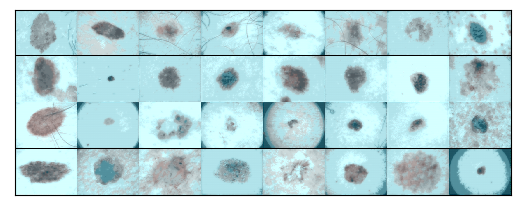

In [25]:
# Reconstructions
show(make_grid(denorm(valid_reconstructions.cpu().data,mean,std)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


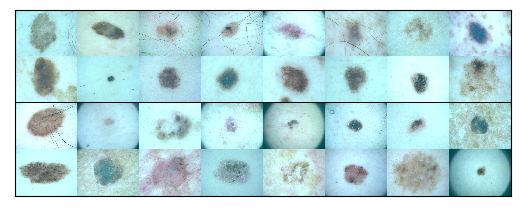

In [26]:
# Originals
show(make_grid(denorm(valid_originals.cpu().data,mean,std)))

## View Embedding

In [29]:
# torch.save(model.state_dict(), 'model_vqvae_e50.pth')

In [27]:
# !pip install umap-learn
import umap

In [32]:
proj = umap.UMAP(n_neighbors=4,
                 min_dist=0.1,
                 metric='cosine').fit_transform(model._vq_vae._embedding.weight.data.cpu())

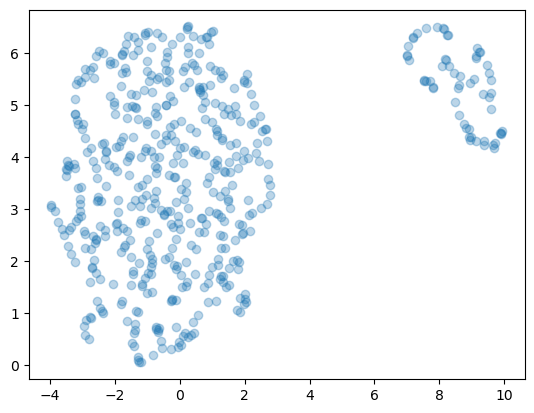

In [33]:
plt.scatter(proj[:,0], proj[:,1], alpha=0.3)

## PSNR Metric

In [25]:
psnr_list = []
for valid_originals in tqdm(validation_loader):
    valid_originals = valid_originals.to(device)

    vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
    _, valid_quantize, _, encodings = model._vq_vae(vq_output_eval)
    valid_reconstructions = model._decoder(valid_quantize)
    mse = F.mse_loss(valid_reconstructions, valid_originals, reduction='none').view(valid_reconstructions.shape[0], -1).mean(dim=1)
    psnr = (-10 * torch.log10(mse)).mean()
    psnr_list.append(psnr.item())
print('PSNR: %.2f' % np.mean(psnr_list))

100%|██████████| 32/32 [00:10<00:00,  3.19it/s]

PSNR: 12.70


In [34]:
torch.cuda.empty_cache()

# Auto Regressive Generation 

In [34]:
model.load_state_dict(torch.load('./model_vqvae.pth')['model'])

<All keys matched successfully>

In [35]:
# model(input)
model.eval()

Model(
  (_encoder): Encoder(
    (_conv_1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (_residual_stack): ResidualStack(
      (_layers): ModuleList(
        (0-1): 2 x Residual(
          (_block): Sequential(
            (0): ReLU(inplace=True)
            (1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (2): ReLU(inplace=True)
            (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
      )
    )
  )
  (_pre_vq_conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  (_vq_vae): VectorQuantizerEMA(
    (_embedding): Embedding(512, 128)
  )
  (_decoder): Decoder(
    (_conv_1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (_residual_stack): ResidualStack(
      (_layers): ModuleList

In [36]:
torch.onnx.export(model, torch.randn(1, 3, 128, 128).to(device), 'model.onnx', verbose=True)

In [37]:
embedding_dim = 128
num_embeddings = 512

## Random Latent Codebook Permutations

In [40]:
N = 32

input_shape = (N, 32, 32, 128)

torch.Size([32768, 1])


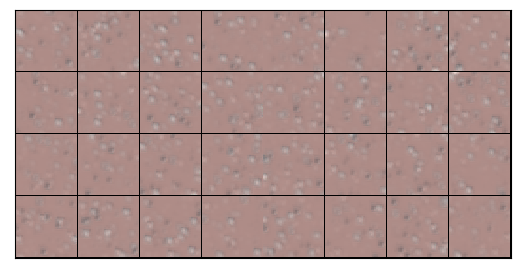

In [41]:

z = torch.randint(0, num_embeddings, (N*32*32,)).unsqueeze(1).to(device)
encodings = torch.zeros(z.shape[0], num_embeddings, device=device)
encodings.scatter_(1, z, 1)
# Quantize and unflatten
print(z.shape)
quantized = torch.matmul(encodings, model._vq_vae._embedding.weight).view(input_shape).permute(0, 3, 1, 2)

x_recon = model._decoder(quantized)
show(make_grid(denorm(x_recon.cpu().data,mean,std)))

In [42]:
import torch
import torch.nn as nn
from torch.nn import functional as F


# hyperparameters
batch_size = 128 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 600000
eval_interval = 500
learning_rate = [4e-4,4e-4,0.00005] # change lr every 200000 steps
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 128 # embedding dimension
n_head = 6
n_layer = 6
dropout = 0.2
vocab_size = 512 + 2 #number of embeddings in the VQ-VAE
torch.manual_seed(1337)

In [43]:


class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTRegressiveModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)  # This token embedding is already fixed
        # self.token_embedding_table  = vq_vae_embedding
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C) 
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


In [44]:
batch_size = 1
training_loader = DataLoader(training_data,
                             batch_size=batch_size,
                             shuffle=True,
                             pin_memory=True,
                            num_workers = 0)
validation_loader = DataLoader(validation_data,
                               batch_size=1,
                               shuffle=True,
                               pin_memory=True,
                              num_workers  = 0)

In [45]:
valid_originals = next(iter(training_loader))
# data = data.to(device)
input_shape = (batch_size,32,32,128)
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, encodings = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


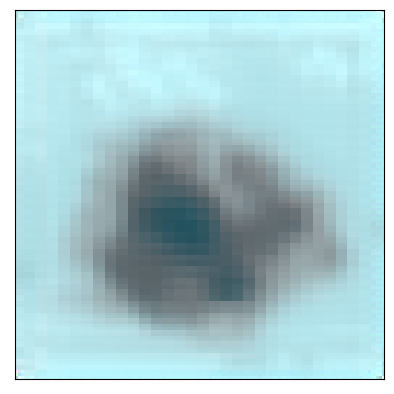

In [46]:
show(make_grid(denorm(valid_reconstructions.cpu().data,mean,std)))

In [47]:
start = torch.tensor([512], dtype=torch.long).to(device)
end = torch.tensor([513], dtype=torch.long).to(device)

In [43]:
import wandb
wandb.login(key="5d1c2f2e3eed3439166d8e749b48bad14e6854f8")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [44]:

modelgpt = GPTRegressiveModel()
m = modelgpt.to(device)
loaded_state_dict = torch.load("/kaggle/input/fork-of-notebook37b2edd6e5/modelgpt_resume.pth")
m.load_state_dict(loaded_state_dict['model'])

run = wandb.init(
    project="VQVAE",
    entity = 'khadgaa',
name = "modelgpt_3_05",
notes = "modelgpt resume training from 4e6 to 6e6 iters. lr=5e-5")

wandb.watch(modelgpt)

# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(modelgpt.parameters(), lr=learning_rate)
optimizer.load_state_dict(loaded_state_dict['optimizer'])

@torch.no_grad()
def estimate_loss(training_loader, validation_loader):
    out = {}
    modelgpt.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            if split == 'train':
                valid_originals = next(iter(training_loader))
            else:
                valid_originals = next(iter(validation_loader))
            # data = data.to(device)
            valid_originals = valid_originals.to(device)
            vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
            _, valid_quantize, _, encodings = model._vq_vae(vq_output_eval)
            valid_reconstructions = model._decoder(valid_quantize)
            encodings = torch.concat((start,encodings.argmax(dim=-1).flatten(),end),dim=0)
            X, Y = get_batch(encodings)
            logits, loss = modelgpt(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    modelgpt.train()
    return out
# # data loading
def get_batch(data):
    # generate a small batch of data of inputs x and targets y
    # data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y
input_shape = (batch_size,32,32,128)


for iters in tqdm(range(max_iters)):

    # every once in a while evaluate the loss on train and val sets
    if iters % eval_interval == 0 or iters == max_iters - 1:
        losses = estimate_loss(training_loader, validation_loader)
        print(f"step {iters}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        wandb.log(losses)
    # sample a batch of data
    
        valid_originals = next(iter(training_loader))
        # data = data.to(device)

        valid_originals = valid_originals.to(device)

        vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
        _, valid_quantize, _, encodings = model._vq_vae(vq_output_eval)
        valid_reconstructions = model._decoder(valid_quantize)
        encodings = torch.concat((start,encodings.argmax(dim=-1).flatten(),end),dim=0)
        xb, yb = get_batch(encodings)

        # evaluate the loss
        logits, loss = modelgpt(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        state_dict = {
            'model': modelgpt.state_dict(),
            'optimizer':optimizer.state_dict(),
            'iters:':iters
        }
        torch.save(state_dict,"/kaggle/working/modelgpt_resume_3.pth")


wandb: Currently logged in as: khadgaa. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.6
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240501_050132-oj666x58
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run modelgpt_3_05
wandb: ⭐️ View project at https://wandb.ai/khadgaa/VQVAE
wandb: 🚀 View run at https://wandb.ai/khadgaa/VQVAE/runs/oj666x58


1.346306 M parameters


  0%|          | 0/200000 [00:00<?, ?it/s]

step 0: train loss 1.4729, val loss 0.7968


  0%|          | 1/200000 [00:48<2715:03:49, 48.87s/it]

step 500: train loss 1.4774, val loss 0.7922


  0%|          | 501/200000 [01:58<11:32:17,  4.80it/s]

step 1000: train loss 1.4692, val loss 0.7651


  1%|          | 1001/200000 [03:07<9:11:13,  6.02it/s]

step 1500: train loss 1.4091, val loss 0.7902


  1%|          | 1501/200000 [04:13<8:19:30,  6.62it/s]

step 2000: train loss 1.4808, val loss 0.8136


  1%|          | 2001/200000 [05:16<7:43:49,  7.11it/s]

step 2500: train loss 1.4739, val loss 0.8111


  1%|▏         | 2501/200000 [06:19<7:26:38,  7.37it/s]

step 3000: train loss 1.4147, val loss 0.8057


  2%|▏         | 3001/200000 [07:21<7:13:17,  7.58it/s]

step 3500: train loss 1.4972, val loss 0.7927


  2%|▏         | 3501/200000 [08:22<7:01:08,  7.78it/s]

step 4000: train loss 1.4520, val loss 0.7595


  2%|▏         | 4001/200000 [09:22<6:51:12,  7.94it/s]

step 4500: train loss 1.4446, val loss 0.8157


  2%|▏         | 4501/200000 [10:20<6:40:07,  8.14it/s]

step 5000: train loss 1.4242, val loss 0.8029


  3%|▎         | 5001/200000 [11:16<6:28:28,  8.37it/s]

step 5500: train loss 1.4083, val loss 0.8334


  3%|▎         | 5501/200000 [12:11<6:17:33,  8.59it/s]

step 6000: train loss 1.3807, val loss 0.7778


  3%|▎         | 6001/200000 [13:06<6:10:41,  8.72it/s]

step 6500: train loss 1.4369, val loss 0.7919


  3%|▎         | 6501/200000 [13:58<5:58:57,  8.98it/s]

step 7000: train loss 1.4349, val loss 0.7846


  4%|▎         | 7001/200000 [14:50<5:49:57,  9.19it/s]

step 7500: train loss 1.4806, val loss 0.8337


  4%|▍         | 7501/200000 [15:44<5:49:22,  9.18it/s]

step 8000: train loss 1.4853, val loss 0.8310


  4%|▍         | 8001/200000 [16:37<5:44:29,  9.29it/s]

step 8500: train loss 1.4537, val loss 0.8015


  4%|▍         | 8501/200000 [17:29<5:40:37,  9.37it/s]

step 9000: train loss 1.4575, val loss 0.7785


  5%|▍         | 9001/200000 [18:30<5:32:40,  9.57it/s]

step 9500: train loss 1.4173, val loss 0.8145


  5%|▍         | 9501/200000 [19:09<5:28:28,  9.67it/s]

step 10000: train loss 1.4873, val loss 0.8286


  5%|▌         | 10001/200000 [20:10<5:21:04,  9.86it/s]

step 10500: train loss 1.3891, val loss 0.7949


  5%|▌         | 10501/200000 [21:00<5:18:22,  9.92it/s]

step 11000: train loss 1.4341, val loss 0.7992


  6%|▌         | 11001/200000 [21:50<5:15:19,  9.99it/s]

step 11500: train loss 1.4160, val loss 0.8206


  6%|▌         | 11501/200000 [22:40<5:09:49, 10.14it/s]

step 12000: train loss 1.4407, val loss 0.7983


  6%|▌         | 12001/200000 [23:30<5:06:24, 10.23it/s]

step 12500: train loss 1.4321, val loss 0.8247


  6%|▋         | 12501/200000 [24:20<5:04:51, 10.25it/s]

step 13000: train loss 1.4377, val loss 0.8218


  7%|▋         | 13001/200000 [25:00<5:01:05, 10.35it/s]

step 13500: train loss 1.3828, val loss 0.8060


  7%|▋         | 13501/200000 [25:50<4:58:56, 10.40it/s]

step 14000: train loss 1.4047, val loss 0.8216


  7%|▋         | 14001/200000 [26:40<4:56:00, 10.47it/s]

step 14500: train loss 1.4834, val loss 0.8457


  7%|▋         | 14501/200000 [27:20<4:52:12, 10.58it/s]

step 15000: train loss 1.5001, val loss 0.9057


  8%|▊         | 15001/200000 [28:10<4:48:48, 10.68it/s]

step 15500: train loss 1.4540, val loss 0.7845


  8%|▊         | 15501/200000 [28:50<4:44:16, 10.82it/s]

step 16000: train loss 1.4129, val loss 0.7940


  8%|▊         | 16001/200000 [29:40<4:41:01, 10.91it/s]

step 16500: train loss 1.4707, val loss 0.8814


  8%|▊         | 16501/200000 [30:20<4:38:03, 11.00it/s]

step 17000: train loss 1.5274, val loss 0.8095


  9%|▊         | 17001/200000 [31:10<4:32:53, 11.18it/s]

step 17500: train loss 1.4856, val loss 0.8312


  9%|▉         | 17501/200000 [31:50<4:32:07, 11.18it/s]

step 18000: train loss 1.5326, val loss 0.8504


  9%|▉         | 18001/200000 [32:40<4:31:09, 11.19it/s]

step 18500: train loss 1.4990, val loss 0.8349


  9%|▉         | 18501/200000 [33:20<4:30:39, 11.18it/s]

step 19000: train loss 1.4018, val loss 0.7874


 10%|▉         | 19001/200000 [34:00<4:28:14, 11.25it/s]

step 19500: train loss 1.4715, val loss 0.8521


 10%|▉         | 19501/200000 [34:50<4:25:34, 11.33it/s]

step 20000: train loss 1.4875, val loss 0.8524


 10%|█         | 20001/200000 [35:30<4:24:06, 11.36it/s]

step 20500: train loss 1.4313, val loss 0.7930


 10%|█         | 20501/200000 [36:10<4:21:32, 11.44it/s]

step 21000: train loss 1.4652, val loss 0.7928


 11%|█         | 21001/200000 [37:00<4:20:34, 11.45it/s]

step 21500: train loss 1.4176, val loss 0.8405


 11%|█         | 21501/200000 [37:40<4:20:39, 11.41it/s]

step 22000: train loss 1.4393, val loss 0.8361


 11%|█         | 22001/200000 [38:30<4:19:36, 11.43it/s]

step 22500: train loss 1.4860, val loss 0.8144


 11%|█▏        | 22501/200000 [39:10<4:20:46, 11.34it/s]

step 23000: train loss 1.4096, val loss 0.7955


 12%|█▏        | 23001/200000 [39:50<4:19:12, 11.38it/s]

step 23500: train loss 1.5360, val loss 0.8251


 12%|█▏        | 23501/200000 [40:40<4:16:31, 11.47it/s]

step 24000: train loss 1.4988, val loss 0.7896


 12%|█▏        | 24001/200000 [41:20<4:15:47, 11.47it/s]

step 24500: train loss 1.5052, val loss 0.8398


 12%|█▏        | 24501/200000 [42:00<4:15:15, 11.46it/s]

step 25000: train loss 1.4512, val loss 0.7916


 13%|█▎        | 25001/200000 [42:50<4:14:08, 11.48it/s]

step 25500: train loss 1.4335, val loss 0.7959


 13%|█▎        | 25501/200000 [43:30<4:12:02, 11.54it/s]

step 26000: train loss 1.4472, val loss 0.8025


 13%|█▎        | 26001/200000 [44:10<4:12:33, 11.48it/s]

step 26500: train loss 1.4368, val loss 0.8089


 13%|█▎        | 26501/200000 [45:00<4:12:43, 11.44it/s]

step 27000: train loss 1.4193, val loss 0.7561


 14%|█▎        | 27001/200000 [45:40<4:11:17, 11.47it/s]

step 27500: train loss 1.4188, val loss 0.8361


 14%|█▍        | 27501/200000 [46:20<4:08:29, 11.57it/s]

step 28000: train loss 1.3862, val loss 0.7955


 14%|█▍        | 28001/200000 [47:10<4:07:20, 11.59it/s]

step 28500: train loss 1.3539, val loss 0.7946


 14%|█▍        | 28501/200000 [47:50<4:05:48, 11.63it/s]

step 29000: train loss 1.4638, val loss 0.7807


 15%|█▍        | 29001/200000 [48:30<4:04:31, 11.66it/s]

step 29500: train loss 1.4078, val loss 0.7673


 15%|█▍        | 29501/200000 [49:20<4:03:56, 11.65it/s]

step 30000: train loss 1.3782, val loss 0.7603


 15%|█▌        | 30001/200000 [50:00<4:03:02, 11.66it/s]

step 30500: train loss 1.4142, val loss 0.7514


 15%|█▌        | 30501/200000 [50:40<4:03:13, 11.61it/s]

step 31000: train loss 1.4488, val loss 0.7552


 16%|█▌        | 31001/200000 [51:20<4:02:54, 11.60it/s]

step 31500: train loss 1.3610, val loss 0.7817


 16%|█▌        | 31501/200000 [52:10<4:04:21, 11.49it/s]

step 32000: train loss 1.3932, val loss 0.7577


 16%|█▌        | 32001/200000 [52:50<4:04:07, 11.47it/s]

step 32500: train loss 1.4236, val loss 0.7291


 16%|█▋        | 32501/200000 [53:40<4:03:40, 11.46it/s]

step 33000: train loss 1.3954, val loss 0.7635


 17%|█▋        | 33001/200000 [54:20<4:03:26, 11.43it/s]

step 33500: train loss 1.4173, val loss 0.7707


 17%|█▋        | 33501/200000 [55:10<4:04:05, 11.37it/s]

step 34000: train loss 1.3981, val loss 0.7651


 17%|█▋        | 34001/200000 [55:50<4:03:36, 11.36it/s]

step 34500: train loss 1.3827, val loss 0.7499


 17%|█▋        | 34501/200000 [56:30<4:03:03, 11.35it/s]

step 35000: train loss 1.3814, val loss 0.7612


 18%|█▊        | 35001/200000 [57:20<4:01:41, 11.38it/s]

step 35500: train loss 1.4105, val loss 0.8189


 18%|█▊        | 35501/200000 [58:00<3:59:50, 11.43it/s]

step 36000: train loss 1.4496, val loss 0.7768


 18%|█▊        | 36001/200000 [58:40<3:59:00, 11.44it/s]

step 36500: train loss 1.4161, val loss 0.7840


 18%|█▊        | 36501/200000 [59:30<3:59:25, 11.38it/s]

step 37000: train loss 1.4295, val loss 0.8108


 19%|█▊        | 37001/200000 [1:00:10<3:59:42, 11.33it/s]

step 37500: train loss 1.4655, val loss 0.7940


 19%|█▉        | 37501/200000 [1:01:00<3:59:39, 11.30it/s]

step 38000: train loss 1.4270, val loss 0.8096


 19%|█▉        | 38001/200000 [1:01:40<3:57:49, 11.35it/s]

step 38500: train loss 1.4576, val loss 0.8003


 19%|█▉        | 38501/200000 [1:02:20<3:56:14, 11.39it/s]

step 39000: train loss 1.3565, val loss 0.8308


 20%|█▉        | 39001/200000 [1:03:10<3:53:55, 11.47it/s]

step 39500: train loss 1.4437, val loss 0.8713


 20%|█▉        | 39501/200000 [1:03:50<3:52:59, 11.48it/s]

step 40000: train loss 1.4943, val loss 0.8539


 20%|██        | 40001/200000 [1:04:30<3:51:31, 11.52it/s]

step 40500: train loss 1.4461, val loss 0.8474


 20%|██        | 40501/200000 [1:05:20<3:50:15, 11.54it/s]

step 41000: train loss 1.3810, val loss 0.8431


 21%|██        | 41001/200000 [1:06:00<3:50:45, 11.48it/s]

step 41500: train loss 1.3978, val loss 0.8769


 21%|██        | 41501/200000 [1:06:51<3:51:14, 11.42it/s]

step 42000: train loss 1.5055, val loss 0.8571


 21%|██        | 42001/200000 [1:07:31<3:51:55, 11.35it/s]

step 42500: train loss 1.4646, val loss 0.8740


 21%|██▏       | 42501/200000 [1:08:11<3:50:12, 11.40it/s]

step 43000: train loss 1.5018, val loss 0.8826


 22%|██▏       | 43001/200000 [1:09:01<3:49:03, 11.42it/s]

step 43500: train loss 1.4811, val loss 0.8534


 22%|██▏       | 43501/200000 [1:09:41<3:48:55, 11.39it/s]

step 44000: train loss 1.4137, val loss 0.8681


 22%|██▏       | 44001/200000 [1:10:31<3:48:44, 11.37it/s]

step 44500: train loss 1.4686, val loss 0.9220


 22%|██▏       | 44501/200000 [1:11:11<3:47:35, 11.39it/s]

step 45000: train loss 1.3872, val loss 0.9064


 23%|██▎       | 45001/200000 [1:11:51<3:46:03, 11.43it/s]

step 45500: train loss 1.4154, val loss 0.8583


 23%|██▎       | 45501/200000 [1:12:41<3:43:43, 11.51it/s]

step 46000: train loss 1.4754, val loss 0.8156


 23%|██▎       | 46001/200000 [1:13:21<3:44:25, 11.44it/s]

step 46500: train loss 1.4502, val loss 0.7913


 23%|██▎       | 46501/200000 [1:14:01<3:42:51, 11.48it/s]

step 47000: train loss 1.4377, val loss 0.7874


 24%|██▎       | 47001/200000 [1:14:51<3:41:33, 11.51it/s]

step 47500: train loss 1.4175, val loss 0.7774


 24%|██▍       | 47501/200000 [1:15:31<3:41:09, 11.49it/s]

step 48000: train loss 1.5061, val loss 0.7413


 24%|██▍       | 48001/200000 [1:16:11<3:42:07, 11.40it/s]

step 48500: train loss 1.4538, val loss 0.7684


 24%|██▍       | 48501/200000 [1:17:01<3:42:08, 11.37it/s]

step 49000: train loss 1.4111, val loss 0.7975


 25%|██▍       | 49001/200000 [1:17:41<3:41:12, 11.38it/s]

step 49500: train loss 1.4384, val loss 0.7627


 25%|██▍       | 49501/200000 [1:18:21<3:37:55, 11.51it/s]

step 50000: train loss 1.4437, val loss 0.7994


 25%|██▌       | 50001/200000 [1:19:11<3:36:15, 11.56it/s]

step 50500: train loss 1.4491, val loss 0.7641


 25%|██▌       | 50501/200000 [1:19:51<3:34:58, 11.59it/s]

step 51000: train loss 1.5106, val loss 0.7759


 26%|██▌       | 51001/200000 [1:20:31<3:34:56, 11.55it/s]

step 51500: train loss 1.4397, val loss 0.7750


 26%|██▌       | 51501/200000 [1:21:21<3:34:19, 11.55it/s]

step 52000: train loss 1.5085, val loss 0.8022


 26%|██▌       | 52001/200000 [1:22:01<3:33:14, 11.57it/s]

step 52500: train loss 1.4812, val loss 0.8045


 26%|██▋       | 52501/200000 [1:22:41<3:31:15, 11.64it/s]

step 53000: train loss 1.4705, val loss 0.8146


 27%|██▋       | 53001/200000 [1:23:31<3:30:38, 11.63it/s]

step 53500: train loss 1.4333, val loss 0.7395


 27%|██▋       | 53501/200000 [1:24:11<3:29:12, 11.67it/s]

step 54000: train loss 1.4643, val loss 0.7464


 27%|██▋       | 54001/200000 [1:24:51<3:28:23, 11.68it/s]

step 54500: train loss 1.4452, val loss 0.7370


 27%|██▋       | 54501/200000 [1:25:31<3:27:55, 11.66it/s]

step 55000: train loss 1.4511, val loss 0.7394


 28%|██▊       | 55001/200000 [1:26:21<3:28:43, 11.58it/s]

step 55500: train loss 1.4297, val loss 0.7674


 28%|██▊       | 55501/200000 [1:27:01<3:29:01, 11.52it/s]

step 56000: train loss 1.4222, val loss 0.7609


 28%|██▊       | 56001/200000 [1:27:51<3:28:51, 11.49it/s]

step 56500: train loss 1.4960, val loss 0.7900


 28%|██▊       | 56501/200000 [1:28:31<3:29:51, 11.40it/s]

step 57000: train loss 1.4651, val loss 0.7614


 29%|██▊       | 57001/200000 [1:29:11<3:30:24, 11.33it/s]

step 57500: train loss 1.4832, val loss 0.7884


 29%|██▉       | 57501/200000 [1:30:01<3:30:20, 11.29it/s]

step 58000: train loss 1.4799, val loss 0.7468


 29%|██▉       | 58001/200000 [1:30:41<3:28:47, 11.33it/s]

step 58500: train loss 1.4386, val loss 0.7854


 29%|██▉       | 58501/200000 [1:31:31<3:27:19, 11.37it/s]

step 59000: train loss 1.4897, val loss 0.7627


 30%|██▉       | 59001/200000 [1:32:11<3:26:29, 11.38it/s]

step 59500: train loss 1.4044, val loss 0.7342


 30%|██▉       | 59501/200000 [1:32:51<3:24:45, 11.44it/s]

step 60000: train loss 1.3939, val loss 0.7862


 30%|███       | 60001/200000 [1:33:41<3:23:47, 11.45it/s]

step 60500: train loss 1.4293, val loss 0.7398


 30%|███       | 60501/200000 [1:34:21<3:24:10, 11.39it/s]

step 61000: train loss 1.4362, val loss 0.7549


 31%|███       | 61001/200000 [1:35:11<3:23:23, 11.39it/s]

step 61500: train loss 1.4265, val loss 0.7664


 31%|███       | 61501/200000 [1:35:51<3:23:27, 11.35it/s]

step 62000: train loss 1.4392, val loss 0.7342


 31%|███       | 62001/200000 [1:36:31<3:23:24, 11.31it/s]

step 62500: train loss 1.4178, val loss 0.7606


 31%|███▏      | 62501/200000 [1:37:21<3:23:41, 11.25it/s]

step 63000: train loss 1.4090, val loss 0.7627


 32%|███▏      | 63001/200000 [1:38:01<3:23:44, 11.21it/s]

step 63500: train loss 1.4206, val loss 0.7746


 32%|███▏      | 63501/200000 [1:38:51<3:21:45, 11.28it/s]

step 64000: train loss 1.4470, val loss 0.7689


 32%|███▏      | 64001/200000 [1:39:31<3:21:04, 11.27it/s]

step 64500: train loss 1.3896, val loss 0.7823


 32%|███▏      | 64501/200000 [1:40:21<3:20:37, 11.26it/s]

step 65000: train loss 1.4294, val loss 0.7530


 33%|███▎      | 65001/200000 [1:41:01<3:21:07, 11.19it/s]

step 65500: train loss 1.3988, val loss 0.7520


 33%|███▎      | 65501/200000 [1:41:51<3:19:49, 11.22it/s]

step 66000: train loss 1.3972, val loss 0.7531


 33%|███▎      | 66001/200000 [1:42:31<3:16:46, 11.35it/s]

step 66500: train loss 1.4061, val loss 0.7449


 33%|███▎      | 66501/200000 [1:43:11<3:15:48, 11.36it/s]

step 67000: train loss 1.3642, val loss 0.7393


 34%|███▎      | 67001/200000 [1:44:01<3:15:03, 11.36it/s]

step 67500: train loss 1.4177, val loss 0.7455


 34%|███▍      | 67501/200000 [1:44:41<3:15:10, 11.31it/s]

step 68000: train loss 1.3829, val loss 0.7517


 34%|███▍      | 68001/200000 [1:45:31<3:13:40, 11.36it/s]

step 68500: train loss 1.3762, val loss 0.7743


 34%|███▍      | 68501/200000 [1:46:11<3:12:45, 11.37it/s]

step 69000: train loss 1.4034, val loss 0.7715


 35%|███▍      | 69001/200000 [1:46:51<3:12:45, 11.33it/s]

step 69500: train loss 1.4386, val loss 0.7800


 35%|███▍      | 69501/200000 [1:47:41<3:10:53, 11.39it/s]

step 70000: train loss 1.4268, val loss 0.7787


 35%|███▌      | 70001/200000 [1:48:21<3:09:23, 11.44it/s]

step 70500: train loss 1.4085, val loss 0.8607


 35%|███▌      | 70501/200000 [1:49:01<3:08:15, 11.46it/s]

step 71000: train loss 1.4012, val loss 0.8280


 36%|███▌      | 71001/200000 [1:49:51<3:06:55, 11.50it/s]

step 71500: train loss 1.4169, val loss 0.8194


 36%|███▌      | 71501/200000 [1:50:31<3:06:52, 11.46it/s]

step 72000: train loss 1.5346, val loss 0.8329


 36%|███▌      | 72001/200000 [1:51:11<3:05:42, 11.49it/s]

step 72500: train loss 1.4464, val loss 0.8873


 36%|███▋      | 72501/200000 [1:52:01<3:07:19, 11.34it/s]

step 73000: train loss 1.4416, val loss 0.9050


 37%|███▋      | 73001/200000 [1:52:41<3:06:26, 11.35it/s]

step 73500: train loss 1.3855, val loss 0.8917


 37%|███▋      | 73501/200000 [1:53:31<3:06:37, 11.30it/s]

step 74000: train loss 1.3978, val loss 0.9028


 37%|███▋      | 74001/200000 [1:54:11<3:05:29, 11.32it/s]

step 74500: train loss 1.3785, val loss 0.9274


 37%|███▋      | 74501/200000 [1:55:01<3:04:13, 11.35it/s]

step 75000: train loss 1.4002, val loss 0.9771


 38%|███▊      | 75001/200000 [1:55:41<3:02:59, 11.39it/s]

step 75500: train loss 1.4218, val loss 0.9142


 38%|███▊      | 75501/200000 [1:56:21<3:02:05, 11.40it/s]

step 76000: train loss 1.4336, val loss 0.9170


 38%|███▊      | 76001/200000 [1:57:11<3:01:00, 11.42it/s]

step 76500: train loss 1.4397, val loss 0.9296


 38%|███▊      | 76501/200000 [1:57:51<2:59:47, 11.45it/s]

step 77000: train loss 1.3921, val loss 0.9295


 39%|███▊      | 77001/200000 [1:58:31<2:59:20, 11.43it/s]

step 77500: train loss 1.4516, val loss 0.8928


 39%|███▉      | 77501/200000 [1:59:21<2:58:54, 11.41it/s]

step 78000: train loss 1.5031, val loss 0.9198


 39%|███▉      | 78001/200000 [2:00:01<2:58:14, 11.41it/s]

step 78500: train loss 1.4745, val loss 0.9102


 39%|███▉      | 78501/200000 [2:00:51<2:56:43, 11.46it/s]

step 79000: train loss 1.4583, val loss 0.9302


 40%|███▉      | 79001/200000 [2:01:31<2:56:37, 11.42it/s]

step 79500: train loss 1.4976, val loss 0.8678


 40%|███▉      | 79501/200000 [2:02:12<2:55:57, 11.41it/s]

step 80000: train loss 1.4123, val loss 0.8686


 40%|████      | 80001/200000 [2:03:02<2:55:36, 11.39it/s]

step 80500: train loss 1.4369, val loss 0.8436


 40%|████      | 80501/200000 [2:03:42<2:55:20, 11.36it/s]

step 81000: train loss 1.5385, val loss 0.7793


 41%|████      | 81001/200000 [2:04:32<2:54:20, 11.38it/s]

step 81500: train loss 1.5041, val loss 0.7760


 41%|████      | 81501/200000 [2:05:12<2:54:17, 11.33it/s]

step 82000: train loss 1.5491, val loss 0.8141


 41%|████      | 82001/200000 [2:05:52<2:52:12, 11.42it/s]

step 82500: train loss 1.4888, val loss 0.7759


 41%|████▏     | 82501/200000 [2:06:42<2:50:38, 11.48it/s]

step 83000: train loss 1.4938, val loss 0.8071


 42%|████▏     | 83001/200000 [2:07:22<2:49:15, 11.52it/s]

step 83500: train loss 1.5274, val loss 0.7910


 42%|████▏     | 83501/200000 [2:08:02<2:48:20, 11.53it/s]

step 84000: train loss 1.5028, val loss 0.8235


 42%|████▏     | 84001/200000 [2:08:52<2:49:54, 11.38it/s]

step 84500: train loss 1.4547, val loss 0.8168


 42%|████▏     | 84501/200000 [2:09:32<2:48:39, 11.41it/s]

step 85000: train loss 1.3889, val loss 0.8144


 43%|████▎     | 85001/200000 [2:10:12<2:46:54, 11.48it/s]

step 85500: train loss 1.4779, val loss 0.8118


 43%|████▎     | 85501/200000 [2:11:02<2:45:25, 11.54it/s]

step 86000: train loss 1.4314, val loss 0.8039


 43%|████▎     | 86001/200000 [2:11:42<2:43:48, 11.60it/s]

step 86500: train loss 1.4322, val loss 0.8088


 43%|████▎     | 86501/200000 [2:12:22<2:43:40, 11.56it/s]

step 87000: train loss 1.4477, val loss 0.8066


 44%|████▎     | 87001/200000 [2:13:12<2:43:38, 11.51it/s]

step 87500: train loss 1.3921, val loss 0.8504


 44%|████▍     | 87501/200000 [2:13:52<2:43:19, 11.48it/s]

step 88000: train loss 1.4471, val loss 0.7713


 44%|████▍     | 88001/200000 [2:14:32<2:42:23, 11.50it/s]

step 88500: train loss 1.4630, val loss 0.7980


 44%|████▍     | 88501/200000 [2:15:22<2:41:17, 11.52it/s]

step 89000: train loss 1.4043, val loss 0.8465


 45%|████▍     | 89001/200000 [2:16:02<2:40:15, 11.54it/s]

step 89500: train loss 1.4327, val loss 0.8108


 45%|████▍     | 89501/200000 [2:16:42<2:39:30, 11.55it/s]

step 90000: train loss 1.3864, val loss 0.8270


 45%|████▌     | 90001/200000 [2:17:32<2:38:21, 11.58it/s]

step 90500: train loss 1.4866, val loss 0.8130


 45%|████▌     | 90501/200000 [2:18:12<2:37:41, 11.57it/s]

step 91000: train loss 1.4164, val loss 0.7832


 46%|████▌     | 91001/200000 [2:18:52<2:37:13, 11.55it/s]

step 91500: train loss 1.4222, val loss 0.8648


 46%|████▌     | 91501/200000 [2:19:42<2:36:15, 11.57it/s]

step 92000: train loss 1.3266, val loss 0.8151


 46%|████▌     | 92001/200000 [2:20:22<2:35:30, 11.57it/s]

step 92500: train loss 1.4351, val loss 0.7933


 46%|████▋     | 92501/200000 [2:21:02<2:34:25, 11.60it/s]

step 93000: train loss 1.3865, val loss 0.8019


 47%|████▋     | 93001/200000 [2:21:42<2:33:18, 11.63it/s]

step 93500: train loss 1.3793, val loss 0.8097


 47%|████▋     | 93501/200000 [2:22:32<2:32:51, 11.61it/s]

step 94000: train loss 1.4130, val loss 0.7900


 47%|████▋     | 94001/200000 [2:23:12<2:32:08, 11.61it/s]

step 94500: train loss 1.3853, val loss 0.7862


 47%|████▋     | 94501/200000 [2:23:52<2:30:00, 11.72it/s]

step 95000: train loss 1.4730, val loss 0.7995


 48%|████▊     | 95001/200000 [2:24:42<2:29:12, 11.73it/s]

step 95500: train loss 1.4523, val loss 0.7770


 48%|████▊     | 95501/200000 [2:25:22<2:28:45, 11.71it/s]

step 96000: train loss 1.4314, val loss 0.7869


 48%|████▊     | 96001/200000 [2:26:02<2:28:14, 11.69it/s]

step 96500: train loss 1.4424, val loss 0.7619


 48%|████▊     | 96501/200000 [2:26:42<2:27:07, 11.73it/s]

step 97000: train loss 1.4520, val loss 0.7896


 49%|████▊     | 97001/200000 [2:27:32<2:25:54, 11.77it/s]

step 97500: train loss 1.3820, val loss 0.8175


 49%|████▉     | 97501/200000 [2:28:12<2:25:07, 11.77it/s]

step 98000: train loss 1.4626, val loss 0.7895


 49%|████▉     | 98001/200000 [2:28:52<2:25:01, 11.72it/s]

step 98500: train loss 1.4517, val loss 0.7577


 49%|████▉     | 98501/200000 [2:29:32<2:24:27, 11.71it/s]

step 99000: train loss 1.3995, val loss 0.7523


 50%|████▉     | 99001/200000 [2:30:22<2:24:20, 11.66it/s]

step 99500: train loss 1.3874, val loss 0.6955


 50%|████▉     | 99501/200000 [2:31:02<2:23:32, 11.67it/s]

step 100000: train loss 1.4067, val loss 0.7670


 50%|█████     | 100001/200000 [2:31:42<2:22:43, 11.68it/s]

step 100500: train loss 1.3710, val loss 0.7623


 50%|█████     | 100501/200000 [2:32:32<2:22:06, 11.67it/s]

step 101000: train loss 1.4363, val loss 0.7519


 51%|█████     | 101001/200000 [2:33:12<2:21:20, 11.67it/s]

step 101500: train loss 1.3856, val loss 0.7441


 51%|█████     | 101501/200000 [2:33:52<2:20:54, 11.65it/s]

step 102000: train loss 1.3952, val loss 0.7245


 51%|█████     | 102001/200000 [2:34:32<2:20:14, 11.65it/s]

step 102500: train loss 1.3967, val loss 0.7398


 51%|█████▏    | 102501/200000 [2:35:22<2:19:50, 11.62it/s]

step 103000: train loss 1.3780, val loss 0.7294


 52%|█████▏    | 103001/200000 [2:36:02<2:19:19, 11.60it/s]

step 103500: train loss 1.4304, val loss 0.7529


 52%|█████▏    | 103501/200000 [2:36:42<2:18:31, 11.61it/s]

step 104000: train loss 1.4335, val loss 0.7643


 52%|█████▏    | 104001/200000 [2:37:32<2:17:54, 11.60it/s]

step 104500: train loss 1.4451, val loss 0.7536


 52%|█████▏    | 104501/200000 [2:38:12<2:17:35, 11.57it/s]

step 105000: train loss 1.4597, val loss 0.7683


 53%|█████▎    | 105001/200000 [2:38:52<2:17:55, 11.48it/s]

step 105500: train loss 1.4727, val loss 0.7562


 53%|█████▎    | 105501/200000 [2:39:42<2:17:38, 11.44it/s]

step 106000: train loss 1.5059, val loss 0.7620


 53%|█████▎    | 106001/200000 [2:40:22<2:17:21, 11.41it/s]

step 106500: train loss 1.4669, val loss 0.7543


 53%|█████▎    | 106501/200000 [2:41:12<2:16:48, 11.39it/s]

step 107000: train loss 1.4566, val loss 0.7693


 54%|█████▎    | 107001/200000 [2:41:52<2:16:06, 11.39it/s]

step 107500: train loss 1.4021, val loss 0.7394


 54%|█████▍    | 107501/200000 [2:42:32<2:15:26, 11.38it/s]

step 108000: train loss 1.4157, val loss 0.7558


 54%|█████▍    | 108001/200000 [2:43:22<2:14:45, 11.38it/s]

step 108500: train loss 1.3862, val loss 0.7567


 54%|█████▍    | 108501/200000 [2:44:02<2:14:16, 11.36it/s]

step 109000: train loss 1.3978, val loss 0.7025


 55%|█████▍    | 109001/200000 [2:44:52<2:13:00, 11.40it/s]

step 109500: train loss 1.3667, val loss 0.7417


 55%|█████▍    | 109501/200000 [2:45:32<2:11:31, 11.47it/s]

step 110000: train loss 1.3863, val loss 0.6889


 55%|█████▌    | 110001/200000 [2:46:12<2:10:03, 11.53it/s]

step 110500: train loss 1.4011, val loss 0.7405


 55%|█████▌    | 110501/200000 [2:47:02<2:08:48, 11.58it/s]

step 111000: train loss 1.3969, val loss 0.7208


 56%|█████▌    | 111001/200000 [2:47:42<2:07:00, 11.68it/s]

step 111500: train loss 1.4446, val loss 0.7322


 56%|█████▌    | 111501/200000 [2:48:22<2:07:01, 11.61it/s]

step 112000: train loss 1.3735, val loss 0.7204


 56%|█████▌    | 112001/200000 [2:49:02<2:05:39, 11.67it/s]

step 112500: train loss 1.4047, val loss 0.7093


 56%|█████▋    | 112501/200000 [2:49:52<2:05:40, 11.60it/s]

step 113000: train loss 1.4641, val loss 0.7403


 57%|█████▋    | 113001/200000 [2:50:32<2:04:08, 11.68it/s]

step 113500: train loss 1.3303, val loss 0.7112


 57%|█████▋    | 113501/200000 [2:51:12<2:03:56, 11.63it/s]

step 114000: train loss 1.4352, val loss 0.7105


 57%|█████▋    | 114001/200000 [2:52:02<2:03:29, 11.61it/s]

step 114500: train loss 1.4700, val loss 0.7365


 57%|█████▋    | 114501/200000 [2:52:42<2:04:49, 11.42it/s]

step 115000: train loss 1.4315, val loss 0.7750


 58%|█████▊    | 115001/200000 [2:53:22<2:04:18, 11.40it/s]

step 115500: train loss 1.3864, val loss 0.8038


 58%|█████▊    | 115501/200000 [2:54:12<2:03:53, 11.37it/s]

step 116000: train loss 1.4327, val loss 0.7650


 58%|█████▊    | 116001/200000 [2:54:52<2:02:29, 11.43it/s]

step 116500: train loss 1.4644, val loss 0.8020


 58%|█████▊    | 116501/200000 [2:55:42<2:01:37, 11.44it/s]

step 117000: train loss 1.3754, val loss 0.7679


 59%|█████▊    | 117001/200000 [2:56:22<1:59:15, 11.60it/s]

step 117500: train loss 1.4173, val loss 0.7732


 59%|█████▉    | 117501/200000 [2:57:02<1:57:50, 11.67it/s]

step 118000: train loss 1.4773, val loss 0.8056


 59%|█████▉    | 118001/200000 [2:57:42<1:56:34, 11.72it/s]

step 118500: train loss 1.4529, val loss 0.7834


 59%|█████▉    | 118501/200000 [2:58:32<1:56:10, 11.69it/s]

step 119000: train loss 1.3422, val loss 0.7843


 60%|█████▉    | 119001/200000 [2:59:12<1:55:46, 11.66it/s]

step 119500: train loss 1.3793, val loss 0.7842


 60%|█████▉    | 119501/200000 [2:59:53<1:55:12, 11.65it/s]

step 120000: train loss 1.4531, val loss 0.8085


 60%|██████    | 120001/200000 [3:00:33<1:54:31, 11.64it/s]

step 120500: train loss 1.4618, val loss 0.7943


 60%|██████    | 120501/200000 [3:01:23<1:54:03, 11.62it/s]

step 121000: train loss 1.4019, val loss 0.8083


 61%|██████    | 121001/200000 [3:02:03<1:53:18, 11.62it/s]

step 121500: train loss 1.4307, val loss 0.8094


 61%|██████    | 121501/200000 [3:02:43<1:52:27, 11.63it/s]

step 122000: train loss 1.3655, val loss 0.8691


 61%|██████    | 122001/200000 [3:03:33<1:52:11, 11.59it/s]

step 122500: train loss 1.3855, val loss 0.8379


 61%|██████▏   | 122501/200000 [3:04:13<1:51:37, 11.57it/s]

step 123000: train loss 1.4103, val loss 0.8514


 62%|██████▏   | 123001/200000 [3:04:53<1:49:47, 11.69it/s]

step 123500: train loss 1.3594, val loss 0.8455


 62%|██████▏   | 123501/200000 [3:05:33<1:48:45, 11.72it/s]

step 124000: train loss 1.4070, val loss 0.8508


 62%|██████▏   | 124001/200000 [3:06:23<1:48:08, 11.71it/s]

step 124500: train loss 1.4024, val loss 0.8475


 62%|██████▏   | 124501/200000 [3:07:03<1:47:59, 11.65it/s]

step 125000: train loss 1.4054, val loss 0.8108


 63%|██████▎   | 125001/200000 [3:07:43<1:47:25, 11.64it/s]

step 125500: train loss 1.3384, val loss 0.7894


 63%|██████▎   | 125501/200000 [3:08:33<1:47:09, 11.59it/s]

step 126000: train loss 1.4089, val loss 0.8248


 63%|██████▎   | 126001/200000 [3:09:13<1:45:50, 11.65it/s]

step 126500: train loss 1.3767, val loss 0.7696


 63%|██████▎   | 126501/200000 [3:09:53<1:44:50, 11.68it/s]

step 127000: train loss 1.3768, val loss 0.7953


 64%|██████▎   | 127001/200000 [3:10:33<1:43:53, 11.71it/s]

step 127500: train loss 1.3974, val loss 0.7664


 64%|██████▍   | 127501/200000 [3:11:23<1:42:45, 11.76it/s]

step 128000: train loss 1.3662, val loss 0.7767


 64%|██████▍   | 128001/200000 [3:12:03<1:41:55, 11.77it/s]

step 128500: train loss 1.3990, val loss 0.7740


 64%|██████▍   | 128501/200000 [3:12:43<1:41:02, 11.79it/s]

step 129000: train loss 1.3596, val loss 0.7643


 65%|██████▍   | 129001/200000 [3:13:23<1:40:27, 11.78it/s]

step 129500: train loss 1.4272, val loss 0.8018


 65%|██████▍   | 129501/200000 [3:14:13<1:40:36, 11.68it/s]

step 130000: train loss 1.4255, val loss 0.8153


 65%|██████▌   | 130001/200000 [3:14:53<1:40:46, 11.58it/s]

step 130500: train loss 1.4162, val loss 0.8016


 65%|██████▌   | 130501/200000 [3:15:33<1:40:16, 11.55it/s]

step 131000: train loss 1.3934, val loss 0.8023


 66%|██████▌   | 131001/200000 [3:16:23<1:39:56, 11.51it/s]

step 131500: train loss 1.3905, val loss 0.8195


 66%|██████▌   | 131501/200000 [3:17:03<1:39:24, 11.48it/s]

step 132000: train loss 1.3857, val loss 0.7775


 66%|██████▌   | 132001/200000 [3:17:53<1:38:42, 11.48it/s]

step 132500: train loss 1.4238, val loss 0.8668


 66%|██████▋   | 132501/200000 [3:18:33<1:39:21, 11.32it/s]

step 133000: train loss 1.4602, val loss 0.8152


 67%|██████▋   | 133001/200000 [3:19:23<1:39:34, 11.21it/s]

step 133500: train loss 1.3996, val loss 0.8041


 67%|██████▋   | 133501/200000 [3:20:03<1:40:08, 11.07it/s]

step 134000: train loss 1.4036, val loss 0.7848


 67%|██████▋   | 134001/200000 [3:20:53<1:39:00, 11.11it/s]

step 134500: train loss 1.4424, val loss 0.8229


 67%|██████▋   | 134501/200000 [3:21:33<1:38:07, 11.13it/s]

step 135000: train loss 1.5022, val loss 0.8134


 68%|██████▊   | 135001/200000 [3:22:23<1:37:30, 11.11it/s]

step 135500: train loss 1.4209, val loss 0.7824


 68%|██████▊   | 135501/200000 [3:23:03<1:37:13, 11.06it/s]

step 136000: train loss 1.4852, val loss 0.7143


 68%|██████▊   | 136001/200000 [3:23:53<1:37:01, 10.99it/s]

step 136500: train loss 1.4989, val loss 0.8062


 68%|██████▊   | 136501/200000 [3:24:43<1:36:15, 10.99it/s]

step 137000: train loss 1.4812, val loss 0.8237


 69%|██████▊   | 137001/200000 [3:25:23<1:35:49, 10.96it/s]

step 137500: train loss 1.4689, val loss 0.8152


 69%|██████▉   | 137501/200000 [3:26:13<1:35:27, 10.91it/s]

step 138000: train loss 1.5178, val loss 0.7959


 69%|██████▉   | 138001/200000 [3:26:53<1:34:30, 10.93it/s]

step 138500: train loss 1.4352, val loss 0.8028


 69%|██████▉   | 138501/200000 [3:27:43<1:33:27, 10.97it/s]

step 139000: train loss 1.4152, val loss 0.8107


 70%|██████▉   | 139001/200000 [3:28:23<1:32:31, 10.99it/s]

step 139500: train loss 1.4573, val loss 0.7899


 70%|██████▉   | 139501/200000 [3:29:13<1:31:42, 11.00it/s]

step 140000: train loss 1.4310, val loss 0.7951


 70%|███████   | 140001/200000 [3:29:53<1:30:42, 11.02it/s]

step 140500: train loss 1.4593, val loss 0.8082


 70%|███████   | 140501/200000 [3:30:43<1:29:45, 11.05it/s]

step 141000: train loss 1.4052, val loss 0.7612


 71%|███████   | 141001/200000 [3:31:23<1:28:33, 11.10it/s]

step 141500: train loss 1.3803, val loss 0.7546


 71%|███████   | 141501/200000 [3:32:13<1:27:59, 11.08it/s]

step 142000: train loss 1.4142, val loss 0.7566


 71%|███████   | 142001/200000 [3:33:03<1:28:30, 10.92it/s]

step 142500: train loss 1.3917, val loss 0.7419


 71%|███████▏  | 142501/200000 [3:33:43<1:28:31, 10.82it/s]

step 143000: train loss 1.3517, val loss 0.7368


 72%|███████▏  | 143001/200000 [3:34:33<1:28:16, 10.76it/s]

step 143500: train loss 1.3960, val loss 0.7583


 72%|███████▏  | 143501/200000 [3:35:23<1:27:49, 10.72it/s]

step 144000: train loss 1.4389, val loss 0.7712


 72%|███████▏  | 144001/200000 [3:36:03<1:27:10, 10.71it/s]

step 144500: train loss 1.4333, val loss 0.7718


 72%|███████▏  | 144501/200000 [3:36:53<1:26:33, 10.69it/s]

step 145000: train loss 1.4116, val loss 0.7300


 73%|███████▎  | 145001/200000 [3:37:43<1:25:39, 10.70it/s]

step 145500: train loss 1.3837, val loss 0.7687


 73%|███████▎  | 145501/200000 [3:38:23<1:24:44, 10.72it/s]

step 146000: train loss 1.4305, val loss 0.7683


 73%|███████▎  | 146001/200000 [3:39:13<1:23:50, 10.73it/s]

step 146500: train loss 1.3975, val loss 0.7488


 73%|███████▎  | 146501/200000 [3:40:03<1:23:11, 10.72it/s]

step 147000: train loss 1.3986, val loss 0.7434


 74%|███████▎  | 147001/200000 [3:40:43<1:22:31, 10.70it/s]

step 147500: train loss 1.2901, val loss 0.7023


 74%|███████▍  | 147501/200000 [3:41:33<1:21:53, 10.69it/s]

step 148000: train loss 1.3651, val loss 0.7492


 74%|███████▍  | 148001/200000 [3:42:23<1:21:15, 10.67it/s]

step 148500: train loss 1.3931, val loss 0.7656


 74%|███████▍  | 148501/200000 [3:43:13<1:20:35, 10.65it/s]

step 149000: train loss 1.3593, val loss 0.7251


 75%|███████▍  | 149001/200000 [3:43:53<1:20:07, 10.61it/s]

step 149500: train loss 1.2617, val loss 0.7320


 75%|███████▍  | 149501/200000 [3:44:43<1:18:35, 10.71it/s]

step 150000: train loss 1.4804, val loss 0.7360


 75%|███████▌  | 150001/200000 [3:45:23<1:17:19, 10.78it/s]

step 150500: train loss 1.4390, val loss 0.7456


 75%|███████▌  | 150501/200000 [3:46:13<1:15:34, 10.92it/s]

step 151000: train loss 1.3852, val loss 0.7725


 76%|███████▌  | 151001/200000 [3:46:53<1:14:26, 10.97it/s]

step 151500: train loss 1.3939, val loss 0.7595


 76%|███████▌  | 151501/200000 [3:47:44<1:13:29, 11.00it/s]

step 152000: train loss 1.4097, val loss 0.7807


 76%|███████▌  | 152001/200000 [3:48:24<1:12:33, 11.02it/s]

step 152500: train loss 1.3608, val loss 0.7765


 76%|███████▋  | 152501/200000 [3:49:14<1:11:30, 11.07it/s]

step 153000: train loss 1.3940, val loss 0.8410


 77%|███████▋  | 153001/200000 [3:49:54<1:10:36, 11.09it/s]

step 153500: train loss 1.3389, val loss 0.7641


 77%|███████▋  | 153501/200000 [3:50:44<1:09:46, 11.11it/s]

step 154000: train loss 1.3641, val loss 0.7453


 77%|███████▋  | 154001/200000 [3:51:24<1:09:00, 11.11it/s]

step 154500: train loss 1.3142, val loss 0.7256


 77%|███████▋  | 154501/200000 [3:52:14<1:08:05, 11.14it/s]

step 155000: train loss 1.3853, val loss 0.7345


 78%|███████▊  | 155001/200000 [3:52:54<1:07:09, 11.17it/s]

step 155500: train loss 1.4139, val loss 0.7245


 78%|███████▊  | 155501/200000 [3:53:44<1:06:25, 11.16it/s]

step 156000: train loss 1.3730, val loss 0.7324


 78%|███████▊  | 156001/200000 [3:54:24<1:05:25, 11.21it/s]

step 156500: train loss 1.3576, val loss 0.7732


 78%|███████▊  | 156501/200000 [3:55:14<1:04:36, 11.22it/s]

step 157000: train loss 1.3733, val loss 0.7766


 79%|███████▊  | 157001/200000 [3:55:54<1:04:14, 11.15it/s]

step 157500: train loss 1.3540, val loss 0.7745


 79%|███████▉  | 157501/200000 [3:56:44<1:03:29, 11.15it/s]

step 158000: train loss 1.3882, val loss 0.7904


 79%|███████▉  | 158001/200000 [3:57:24<1:02:32, 11.19it/s]

step 158500: train loss 1.3718, val loss 0.8105


 79%|███████▉  | 158501/200000 [3:58:04<1:01:42, 11.21it/s]

step 159000: train loss 1.3871, val loss 0.8273


 80%|███████▉  | 159001/200000 [3:58:54<1:00:53, 11.22it/s]

step 159500: train loss 1.4141, val loss 0.8367


 80%|███████▉  | 159501/200000 [3:59:34<59:51, 11.28it/s]

step 160000: train loss 1.4014, val loss 0.8155


 80%|████████  | 160001/200000 [4:00:24<59:11, 11.26it/s]

step 160500: train loss 1.3808, val loss 0.7277


 80%|████████  | 160501/200000 [4:01:04<58:34, 11.24it/s]

step 161000: train loss 1.3555, val loss 0.7608


 81%|████████  | 161001/200000 [4:01:54<57:53, 11.23it/s]

step 161500: train loss 1.4031, val loss 0.7569


 81%|████████  | 161501/200000 [4:02:34<57:06, 11.24it/s]

step 162000: train loss 1.3677, val loss 0.7602


 81%|████████  | 162001/200000 [4:03:24<56:14, 11.26it/s]

step 162500: train loss 1.3733, val loss 0.7191


 81%|████████▏ | 162501/200000 [4:04:04<55:21, 11.29it/s]

step 163000: train loss 1.4110, val loss 0.7572


 82%|████████▏ | 163001/200000 [4:04:44<54:34, 11.30it/s]

step 163500: train loss 1.3808, val loss 0.7375


 82%|████████▏ | 163501/200000 [4:05:34<54:14, 11.22it/s]

step 164000: train loss 1.3780, val loss 0.7620


 82%|████████▏ | 164001/200000 [4:06:24<54:01, 11.10it/s]

step 164500: train loss 1.3598, val loss 0.7691


 82%|████████▏ | 164501/200000 [4:07:04<53:11, 11.12it/s]

step 165000: train loss 1.4418, val loss 0.7911


 83%|████████▎ | 165001/200000 [4:07:54<52:53, 11.03it/s]

step 165500: train loss 1.4117, val loss 0.7596


 83%|████████▎ | 165501/200000 [4:08:34<52:10, 11.02it/s]

step 166000: train loss 1.4094, val loss 0.7922


 83%|████████▎ | 166001/200000 [4:09:24<51:20, 11.04it/s]

step 166500: train loss 1.3951, val loss 0.7446


 83%|████████▎ | 166501/200000 [4:10:04<50:35, 11.04it/s]

step 167000: train loss 1.3657, val loss 0.7175


 84%|████████▎ | 167001/200000 [4:10:54<49:45, 11.05it/s]

step 167500: train loss 1.4175, val loss 0.7387


 84%|████████▍ | 167501/200000 [4:11:34<48:59, 11.06it/s]

step 168000: train loss 1.3905, val loss 0.7215


 84%|████████▍ | 168001/200000 [4:12:24<48:12, 11.06it/s]

step 168500: train loss 1.3505, val loss 0.7469


 84%|████████▍ | 168501/200000 [4:13:04<47:15, 11.11it/s]

step 169000: train loss 1.4366, val loss 0.7661


 85%|████████▍ | 169001/200000 [4:13:44<45:57, 11.24it/s]

step 169500: train loss 1.4419, val loss 0.7459


 85%|████████▍ | 169501/200000 [4:14:34<44:54, 11.32it/s]

step 170000: train loss 1.3578, val loss 0.7478


 85%|████████▌ | 170001/200000 [4:15:14<44:09, 11.32it/s]

step 170500: train loss 1.4060, val loss 0.7810


 85%|████████▌ | 170501/200000 [4:16:04<43:35, 11.28it/s]

step 171000: train loss 1.4755, val loss 0.7739


 86%|████████▌ | 171001/200000 [4:16:44<43:06, 11.21it/s]

step 171500: train loss 1.5114, val loss 0.7596


 86%|████████▌ | 171501/200000 [4:17:34<42:33, 11.16it/s]

step 172000: train loss 1.4889, val loss 0.7851


 86%|████████▌ | 172001/200000 [4:18:14<41:27, 11.26it/s]

step 172500: train loss 1.5019, val loss 0.7549


 86%|████████▋ | 172501/200000 [4:18:54<40:31, 11.31it/s]

step 173000: train loss 1.5230, val loss 0.7494


 87%|████████▋ | 173001/200000 [4:19:44<39:40, 11.34it/s]

step 173500: train loss 1.5082, val loss 0.7833


 87%|████████▋ | 173501/200000 [4:20:24<38:47, 11.38it/s]

step 174000: train loss 1.4757, val loss 0.7878


 87%|████████▋ | 174001/200000 [4:21:14<38:00, 11.40it/s]

step 174500: train loss 1.5241, val loss 0.7685


 87%|████████▋ | 174501/200000 [4:21:54<37:07, 11.45it/s]

step 175000: train loss 1.5428, val loss 0.7400


 88%|████████▊ | 175001/200000 [4:22:34<36:27, 11.43it/s]

step 175500: train loss 1.4720, val loss 0.7776


 88%|████████▊ | 175501/200000 [4:23:24<35:52, 11.38it/s]

step 176000: train loss 1.3969, val loss 0.7686


 88%|████████▊ | 176001/200000 [4:24:04<35:26, 11.29it/s]

step 176500: train loss 1.4590, val loss 0.7738


 88%|████████▊ | 176501/200000 [4:24:54<34:51, 11.24it/s]

step 177000: train loss 1.4174, val loss 0.7462


 89%|████████▊ | 177001/200000 [4:25:34<34:09, 11.22it/s]

step 177500: train loss 1.5501, val loss 0.7367


 89%|████████▉ | 177501/200000 [4:26:24<33:23, 11.23it/s]

step 178000: train loss 1.4943, val loss 0.7541


 89%|████████▉ | 178001/200000 [4:27:04<32:34, 11.25it/s]

step 178500: train loss 1.4127, val loss 0.7529


 89%|████████▉ | 178501/200000 [4:27:54<32:00, 11.20it/s]

step 179000: train loss 1.4316, val loss 0.7399


 90%|████████▉ | 179001/200000 [4:28:34<31:20, 11.17it/s]

step 179500: train loss 1.4347, val loss 0.7737


 90%|████████▉ | 179501/200000 [4:29:24<30:36, 11.16it/s]

step 180000: train loss 1.4776, val loss 0.7485


 90%|█████████ | 180001/200000 [4:30:04<29:51, 11.17it/s]

step 180500: train loss 1.4311, val loss 0.7516


 90%|█████████ | 180501/200000 [4:30:44<29:00, 11.20it/s]

step 181000: train loss 1.4960, val loss 0.7509


 91%|█████████ | 181001/200000 [4:31:34<28:20, 11.17it/s]

step 181500: train loss 1.4533, val loss 0.7290


 91%|█████████ | 181501/200000 [4:32:14<27:31, 11.20it/s]

step 182000: train loss 1.3883, val loss 0.7488


 91%|█████████ | 182001/200000 [4:33:04<26:57, 11.13it/s]

step 182500: train loss 1.4735, val loss 0.7333


 91%|█████████▏| 182501/200000 [4:33:54<26:15, 11.11it/s]

step 183000: train loss 1.4145, val loss 0.7608


 92%|█████████▏| 183001/200000 [4:34:34<25:38, 11.05it/s]

step 183500: train loss 1.4572, val loss 0.7634


 92%|█████████▏| 183501/200000 [4:35:24<25:02, 10.98it/s]

step 184000: train loss 1.4730, val loss 0.7635


 92%|█████████▏| 184001/200000 [4:36:04<24:25, 10.92it/s]

step 184500: train loss 1.4458, val loss 0.7399


 92%|█████████▏| 184501/200000 [4:36:54<23:42, 10.89it/s]

step 185000: train loss 1.4938, val loss 0.7479


 93%|█████████▎| 185001/200000 [4:37:44<23:02, 10.85it/s]

step 185500: train loss 1.4646, val loss 0.7370


 93%|█████████▎| 185501/200000 [4:38:25<22:15, 10.86it/s]

step 186000: train loss 1.3933, val loss 0.7368


 93%|█████████▎| 186001/200000 [4:39:15<21:26, 10.88it/s]

step 186500: train loss 1.4457, val loss 0.7058


 93%|█████████▎| 186501/200000 [4:39:55<20:44, 10.85it/s]

step 187000: train loss 1.4512, val loss 0.7427


 94%|█████████▎| 187001/200000 [4:40:45<20:00, 10.83it/s]

step 187500: train loss 1.4185, val loss 0.7387


 94%|█████████▍| 187501/200000 [4:41:35<19:16, 10.81it/s]

step 188000: train loss 1.3427, val loss 0.7203


 94%|█████████▍| 188001/200000 [4:42:15<18:28, 10.83it/s]

step 188500: train loss 1.5038, val loss 0.7185


 94%|█████████▍| 188501/200000 [4:43:05<17:45, 10.79it/s]

step 189000: train loss 1.5077, val loss 0.7448


 95%|█████████▍| 189001/200000 [4:43:45<16:46, 10.93it/s]

step 189500: train loss 1.4464, val loss 0.7455


 95%|█████████▍| 189501/200000 [4:44:35<15:49, 11.05it/s]

step 190000: train loss 1.4130, val loss 0.7002


 95%|█████████▌| 190001/200000 [4:45:15<14:55, 11.17it/s]

step 190500: train loss 1.3452, val loss 0.7479


 95%|█████████▌| 190501/200000 [4:46:05<14:10, 11.18it/s]

step 191000: train loss 1.4441, val loss 0.7553


 96%|█████████▌| 191001/200000 [4:46:45<13:37, 11.01it/s]

step 191500: train loss 1.3718, val loss 0.6994


 96%|█████████▌| 191501/200000 [4:47:35<12:56, 10.95it/s]

step 192000: train loss 1.3846, val loss 0.7063


 96%|█████████▌| 192001/200000 [4:48:25<12:15, 10.88it/s]

step 192500: train loss 1.3788, val loss 0.7468


 96%|█████████▋| 192501/200000 [4:49:05<11:25, 10.94it/s]

step 193000: train loss 1.3786, val loss 0.7427


 97%|█████████▋| 193001/200000 [4:49:55<10:37, 10.99it/s]

step 193500: train loss 1.3985, val loss 0.7508


 97%|█████████▋| 193501/200000 [4:50:35<09:47, 11.06it/s]

step 194000: train loss 1.5121, val loss 0.7260


 97%|█████████▋| 194001/200000 [4:51:25<09:00, 11.10it/s]

step 194500: train loss 1.3677, val loss 0.7356


 97%|█████████▋| 194501/200000 [4:52:05<08:15, 11.10it/s]

step 195000: train loss 1.3927, val loss 0.7370


 98%|█████████▊| 195001/200000 [4:52:55<07:33, 11.02it/s]

step 195500: train loss 1.4544, val loss 0.7869


 98%|█████████▊| 195501/200000 [4:53:35<06:50, 10.96it/s]

step 196000: train loss 1.5245, val loss 0.7437


 98%|█████████▊| 196001/200000 [4:54:25<06:05, 10.95it/s]

step 196500: train loss 1.3715, val loss 0.7409


 98%|█████████▊| 196501/200000 [4:55:05<05:15, 11.09it/s]

step 197000: train loss 1.4361, val loss 0.7329


 99%|█████████▊| 197001/200000 [4:55:45<04:25, 11.27it/s]

step 197500: train loss 1.3887, val loss 0.7884


 99%|█████████▉| 197501/200000 [4:56:35<03:39, 11.36it/s]

step 198000: train loss 1.4609, val loss 0.7702


 99%|█████████▉| 198001/200000 [4:57:15<02:55, 11.41it/s]

step 198500: train loss 1.3350, val loss 0.8065


 99%|█████████▉| 198501/200000 [4:57:55<02:10, 11.49it/s]

step 199000: train loss 1.4742, val loss 0.7653


100%|█████████▉| 199001/200000 [4:58:45<01:26, 11.49it/s]

step 199500: train loss 1.3525, val loss 0.7797


100%|█████████▉| 199501/200000 [4:59:25<00:43, 11.54it/s]

step 199999: train loss 1.3944, val loss 0.7783


100%|██████████| 200000/200000 [4:59:54<00:00, 11.11it/s]


# Inference Functions

## Auto Regressive model Inference

In [48]:
modelgpt = GPTRegressiveModel()
m = modelgpt.to(device)
loaded_state_dict = torch.load("./modelgpt_resume_3.pth")
m.load_state_dict(loaded_state_dict['model'])

<All keys matched successfully>

In [49]:
N = 32
with torch.no_grad():
    generated_encodes = []
    context = torch.tensor([[512]]*N, dtype=torch.long, device=device)
    generated_encode  = m.generate(context , max_new_tokens=1025)

generated_encode = generated_encode[:,1:-1]
mode,_ = torch.mode(generated_encode,dim = 1)
generated_encode=torch.where(generated_encode==512,mode.unsqueeze(1),generated_encode)
generated_encode=torch.where(generated_encode==513,mode.unsqueeze(1),generated_encode)

In [50]:
generated_encodes_ = generated_encode.reshape(-1,1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


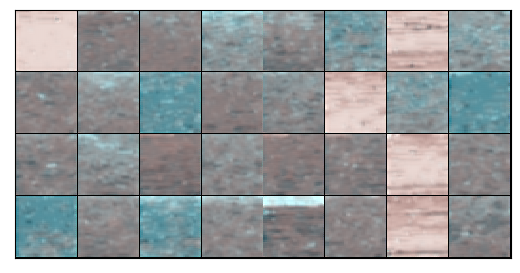

In [51]:
input_shape = (N, 32, 32, 128)
encodings = torch.zeros(generated_encodes_.shape[0], num_embeddings, device=device)
encodings.scatter_(1, generated_encodes_, 1)
quantized = torch.matmul(encodings, model._vq_vae._embedding.weight).view(input_shape).permute(0, 3, 1, 2)

x_recon = model._decoder(quantized)
show(make_grid(denorm(x_recon.cpu().data,mean,std)))

## VQVAE Model Inference

In [21]:
model.eval()
model.load_state_dict(torch.load('./model_vqvae.pth')['model'])


<All keys matched successfully>

In [28]:
def infer_vqvae(img_path):
    img_transform= transforms.Compose([ transforms.ToTensor(),transforms.Normalize(mean, std)])
    image = open_image(img_path)
    valid_originals = img_transform(image).unsqueeze(0)
    valid_originals = valid_originals.to(device)
    vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals)) 
    _, valid_quantize, _, encodings = model._vq_vae(vq_output_eval)
    valid_reconstructions = model._decoder(valid_quantize)
    # Reconstructions
    plt.subplot(1,2,1)
    show(make_grid(denorm(valid_originals.cpu().data,mean,std)))
    plt.title('Original')
    plt.subplot(1,2,2)
    show(make_grid(denorm(valid_reconstructions.cpu().data,mean,std)))
    plt.title('Reconstructions')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


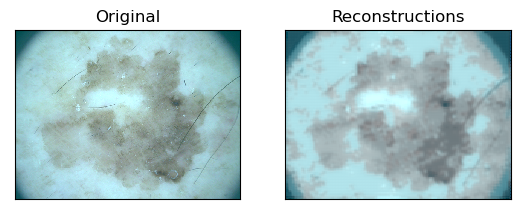

In [29]:
img_path = os.path.join(root, 'Test/Test_data', 'ISIC_0033321.jpg')
infer_vqvae(img_path)